In [1]:
# ==========================================================================================
# Handwritten Character Recognition using Convolutional Neural Network (CNN)
# ==========================================================================================
# Description:
# This project implements a CNN-based approach to recognize handwritten English characters 
# (A-Z). It leverages a labeled dataset of grayscale images, where each image corresponds 
# to an uppercase English alphabet. The goal is to accurately classify each character using 
# deep learning techniques with PyTorch.
# ==========================================================================================

In [2]:
# Importing Required Libraries

# Data manipulation and visualization
import numpy as np                          # Numerical computations
import pandas as pd                         # Data handling and preprocessing
import matplotlib.pyplot as plt             # Basic plotting
import seaborn as sns                       # Advanced visualization

# PyTorch - Deep Learning Framework
import torch                                # Core PyTorch module
import torch.nn as nn                       # Neural network components
import torch.nn.functional as F             # Functional API for layers and activations
from torch.utils.data import Dataset, DataLoader  # Custom dataset handling and batching

# Scikit-learn - Model evaluation and splitting
from sklearn.model_selection import train_test_split  # Splitting dataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay  # Evaluation

# Progress bar utility
from tqdm.auto import tqdm                  # For displaying training progress

In [3]:
# Checking for GPU Availability

# Let's check if a GPU is available for faster training; otherwise, we'll use the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Printing the device that will be used for training
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Loading the Dataset

# Load the handwritten character dataset (make sure the path is correct for your setup)
data = pd.read_csv('C:/Users/VANSH/OneDrive/Desktop/Project/Character_recognition/Data/A-Z_Data.csv')

# Display the shape of the dataset to get an idea of how many samples and features we have
print("Shape of the dataset:", data.shape)

# Display the first few rows to quickly inspect the structure and format
data.head()

Shape of the dataset: (372450, 785)


,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


C:\Users\VANSH\AppData\Local\Temp\ipykernel_3032\1259435372.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['0'], palette="crest")


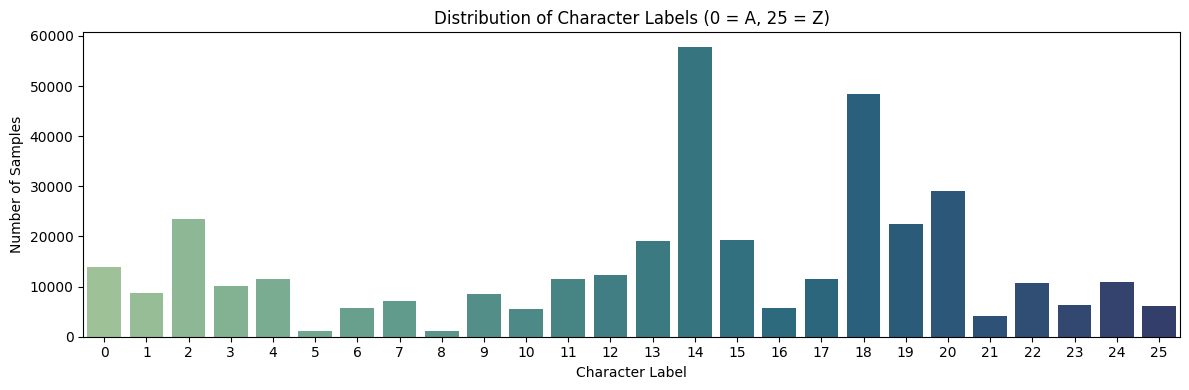

In [5]:
# Visualizing the Distribution of Character Labels

# Plotting the count of each character label (0 represents 'A', 25 represents 'Z')
plt.figure(figsize=(12, 4))
sns.countplot(x=data['0'], palette="crest")

# Adding meaningful titles and axis labels
plt.title("Distribution of Character Labels (0 = A, 25 = Z)")
plt.xlabel("Character Label")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

In [6]:
# Step 1: Separating Features and Labels + Normalizing Input Images

# Split the dataset into features (X) and labels (y)
X = data.drop('0', axis=1).values / 255.0  # Normalize pixel values to [0, 1]
y = data['0'].values                       # Labels (0 = A, 25 = Z)

# Reshape X to match CNN input shape: (samples, channels, height, width)
X = X.reshape(-1, 1, 28, 28).astype(np.float32)

# Sanity check
print(f"Feature shape: {X.shape}, Label shape: {y.shape}")

Feature shape: (372450, 1, 28, 28), Label shape: (372450,)


In [7]:
# Step 2: Train-Test Split with Stratified Sampling

# Split the dataset into training and testing sets
# Stratify ensures that the distribution of character classes remains balanced in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,       # Use 20% of the data for testing
    stratify=y,          # Preserve label distribution
    random_state=42      # For reproducibility
)

# Display the number of samples in each set
print(f"Number of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")

Number of training samples: 297960
Number of testing samples: 74490


In [8]:
# Step 3: Define Custom Dataset for Character Recognition

class CharacterDataset(Dataset):
    # Custom PyTorch Dataset for loading character images and labels.
    # Each image is expected to be a 28x28 grayscale image, normalized and reshaped.
    
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        # Return total number of samples
        return len(self.images)

    def __getitem__(self, idx):
        # Fetch the image and label at the given index and convert them to tensors
        image = torch.tensor(self.images[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

In [9]:
# Step 4: Create Dataset and DataLoader Instances

# Wrap the training and testing data into PyTorch Dataset objects
train_dataset = CharacterDataset(X_train, y_train)
test_dataset = CharacterDataset(X_test, y_test)

# Create DataLoader objects for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)   # Shuffle for training
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)    # No shuffle for evaluation

In [10]:
# Step 5: Define the Convolutional Neural Network (CNN) Architecture

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # First convolutional layer: 1 input channel -> 32 output channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)

        # Second convolutional layer: 32 input channels -> 64 output channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Max pooling layer with kernel size 2x2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=64 * 7 * 7, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=26)  # Output: 26 classes (A-Z)

    def forward(self, x):
        # Apply convolution -> ReLU -> pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Apply dropout
        x = self.dropout(x)

        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 64 * 7 * 7)

        # Fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Instantiate the model and move it to the configured device (CPU or GPU)
model = CNNModel().to(device)

In [11]:
# Step 6: Define the Loss Function and Optimizer

# CrossEntropyLoss is suitable for multi-class classification problems
criterion = nn.CrossEntropyLoss()

# Adam optimizer with a learning rate of 0.001 (commonly a good starting point)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Step 7: Training Loop with Accuracy and Loss Tracking

# Lists to store training loss and accuracy after each epoch
train_losses = []
train_accuracies = []

def train_model(epochs):
    
    # Trains the CNN model for a given number of epochs and logs progress with tqdm.
    model.train()  # Set the model to training mode

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # tqdm loop for real-time progress bar
        loop = tqdm(train_loader, leave=False)

        for inputs, labels in loop:
            inputs = inputs.to(device).float()      # Move inputs to GPU and ensure float dtype
            labels = labels.to(device).long()       # Move labels to GPU and ensure long dtype

            optimizer.zero_grad()                   # Clear previous gradients
            outputs = model(inputs)                 # Forward pass
            loss = criterion(outputs, labels)       # Compute loss
            loss.backward()                         # Backward pass
            optimizer.step()                        # Update weights

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update tqdm progress bar
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Print summary after each epoch
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.2f}%")

In [13]:
# Step 8: Start Training the CNN Model

# Begin training for 20 epochs
train_model(epochs=20)

  0%|          | 0/4656 [00:00<?, ?it/s]

Epoch [1/20] - Loss: 871.1147 - Accuracy: 94.58%


  0%|          | 0/4656 [00:00<?, ?it/s]

Epoch [2/20] - Loss: 381.9087 - Accuracy: 97.64%


  0%|          | 0/4656 [00:00<?, ?it/s]

Epoch [3/20] - Loss: 290.6011 - Accuracy: 98.19%


  0%|          | 0/4656 [00:00<?, ?it/s]

Epoch [4/20] - Loss: 243.2622 - Accuracy: 98.45%


  0%|          | 0/4656 [00:00<?, ?it/s]

Epoch [5/20] - Loss: 205.4106 - Accuracy: 98.67%


  0%|          | 0/4656 [00:00<?, ?it/s]

Epoch [6/20] - Loss: 184.7250 - Accuracy: 98.82%


  0%|          | 0/4656 [00:00<?, ?it/s]

Epoch [7/20] - Loss: 166.5597 - Accuracy: 98.88%


  0%|          | 0/4656 [00:00<?, ?it/s]

Epoch [8/20] - Loss: 148.6990 - Accuracy: 99.00%


  0%|          | 0/4656 [00:00<?, ?it/s]

Epoch [9/20] - Loss: 138.0656 - Accuracy: 99.06%


  0%|          | 0/4656 [00:00<?, ?it/s]

Epoch [10/20] - Loss: 128.7870 - Accuracy: 99.11%


  0%|          | 0/4656 [00:00<?, ?it/s]

Epoch [11/20] - Loss: 120.9245 - Accuracy: 99.16%


  0%|          | 0/4656 [00:00<?, ?it/s]

Epoch [12/20] - Loss: 115.4978 - Accuracy: 99.20%


  0%|          | 0/4656 [00:00<?, ?it/s]

Epoch [13/20] - Loss: 106.7123 - Accuracy: 99.26%


  0%|          | 0/4656 [00:00<?, ?it/s]

Epoch [14/20] - Loss: 105.2083 - Accuracy: 99.27%


  0%|          | 0/4656 [00:00<?, ?it/s]

Epoch [15/20] - Loss: 99.0107 - Accuracy: 99.31%


  0%|          | 0/4656 [00:00<?, ?it/s]

Epoch [16/20] - Loss: 94.0962 - Accuracy: 99.34%


  0%|          | 0/4656 [00:00<?, ?it/s]

Epoch [17/20] - Loss: 93.8660 - Accuracy: 99.36%


  0%|          | 0/4656 [00:00<?, ?it/s]

Epoch [18/20] - Loss: 92.9897 - Accuracy: 99.36%


  0%|          | 0/4656 [00:00<?, ?it/s]

Epoch [19/20] - Loss: 88.4474 - Accuracy: 99.39%


  0%|          | 0/4656 [00:00<?, ?it/s]

Epoch [20/20] - Loss: 88.6850 - Accuracy: 99.39%


In [14]:
# Step 9: Evaluate Model Performance on Test Set

# Switch model to evaluation mode (disables dropout, etc.)
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

# Disable gradient computation for evaluation (improves speed & reduces memory usage)
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()

        outputs = model(inputs)

        # Get predicted class with highest score
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Save predictions and actual labels for further evaluation
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print overall test accuracy
print(f"✅ Test Accuracy: {100 * correct / total:.2f}%")

✅ Test Accuracy: 99.53%


In [15]:
# Step 10: Define Class Labels

# Generate a list of uppercase English alphabets ['A', 'B', ..., 'Z']
classes = [chr(i) for i in range(ord('A'), ord('Z') + 1)]

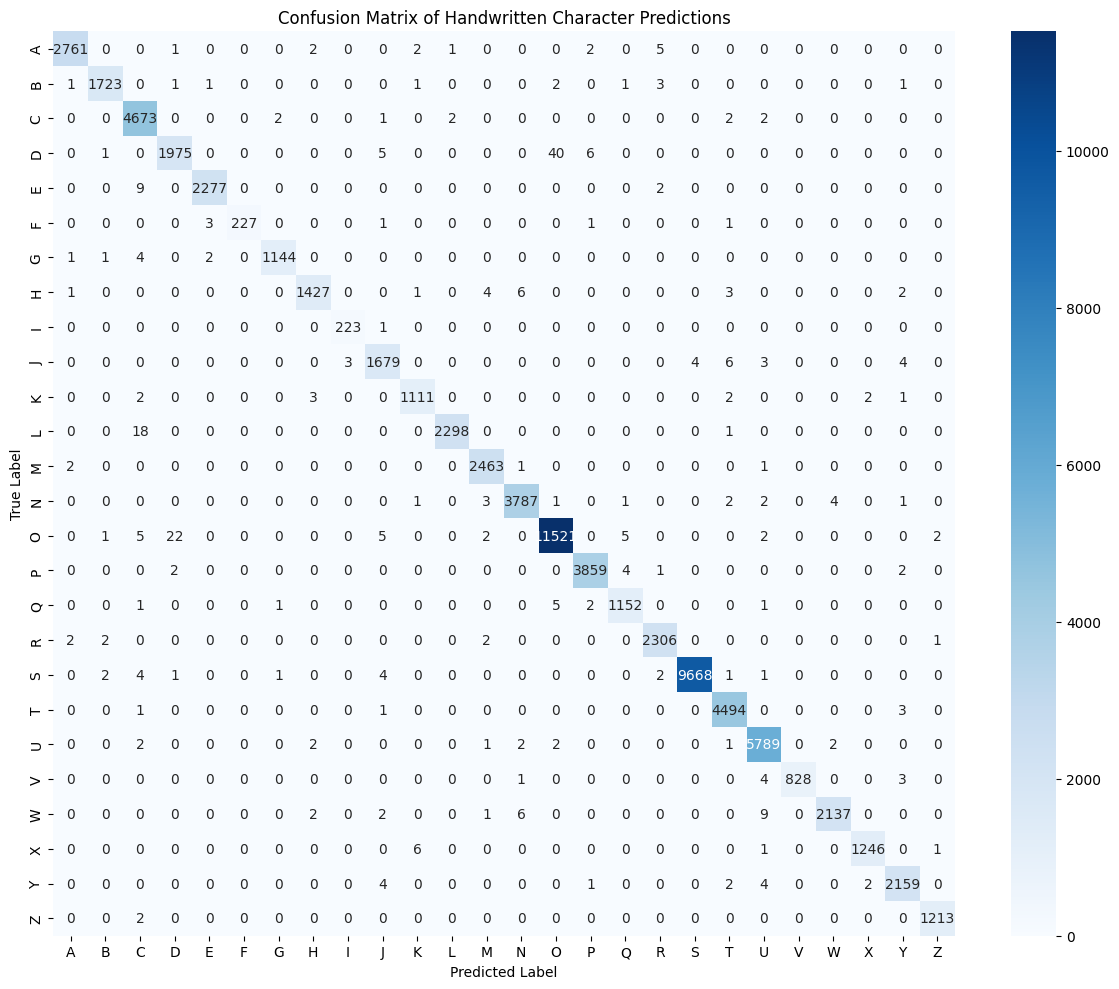

In [16]:
# Step 11: Confusion Matrix Visualization

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)

# Set plot labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Handwritten Character Predictions')
plt.tight_layout()
plt.show()

In [17]:
# Step 12: Classification Report

# Display precision, recall, f1-score and support for each class
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))

Classification Report:

              precision    recall  f1-score   support

           A       1.00      1.00      1.00      2774
           B       1.00      0.99      0.99      1734
           C       0.99      1.00      0.99      4682
           D       0.99      0.97      0.98      2027
           E       1.00      1.00      1.00      2288
           F       1.00      0.97      0.99       233
           G       1.00      0.99      0.99      1152
           H       0.99      0.99      0.99      1444
           I       0.99      1.00      0.99       224
           J       0.99      0.99      0.99      1699
           K       0.99      0.99      0.99      1121
           L       1.00      0.99      1.00      2317
           M       0.99      1.00      1.00      2467
           N       1.00      1.00      1.00      3802
           O       1.00      1.00      1.00     11565
           P       1.00      1.00      1.00      3868
           Q       0.99      0.99      0.99      1162
   

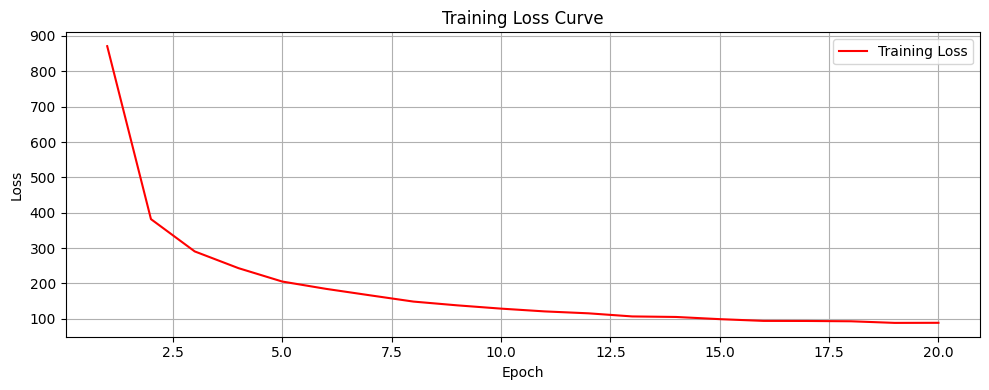

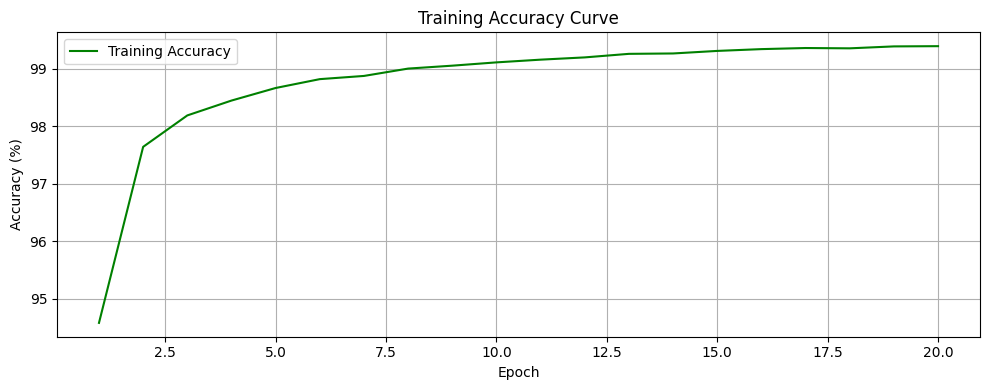

In [18]:
# Step 13: Training Performance Visualization - Loss & Accuracy Curves

# Plot the Training Loss Curve
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the Training Accuracy Curve
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

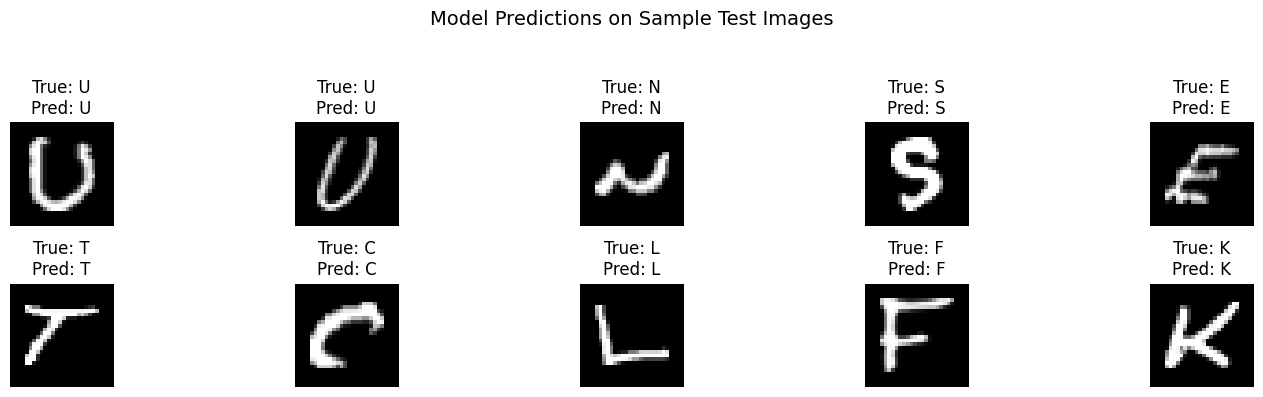

In [19]:
# Step 14: Visualizing Model Predictions on Test Samples

def imshow(img):

    # Utility function to display a single grayscale image.
    img = img.squeeze().numpy()  # Remove channel dimension and convert to numpy
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# Fetch a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move data to the appropriate device
images = images.to(device).float()
labels = labels.to(device)

# Get model predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Plot first 10 images with predicted vs actual labels
plt.figure(figsize=(15, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    imshow(images[i].cpu())
    plt.title(f"True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}")
plt.suptitle("Model Predictions on Sample Test Images", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

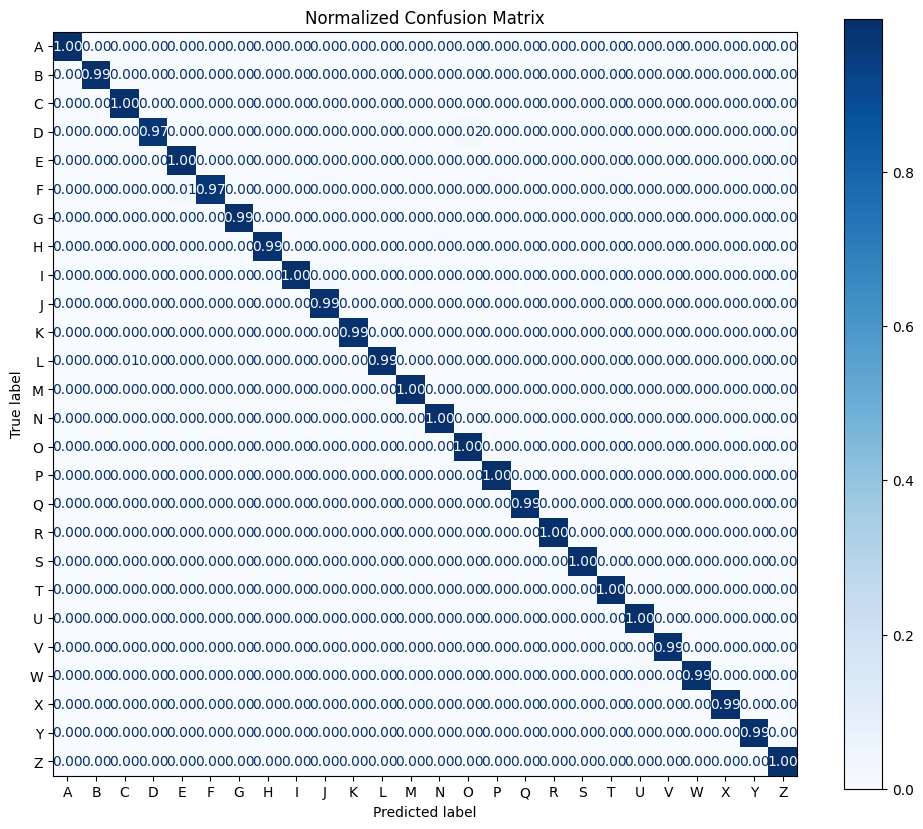

In [20]:
# Step 15: Visualizing the Normalized Confusion Matrix

# Normalize the confusion matrix by row (true labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create and plot the normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes)
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(cmap='Blues', ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.show()

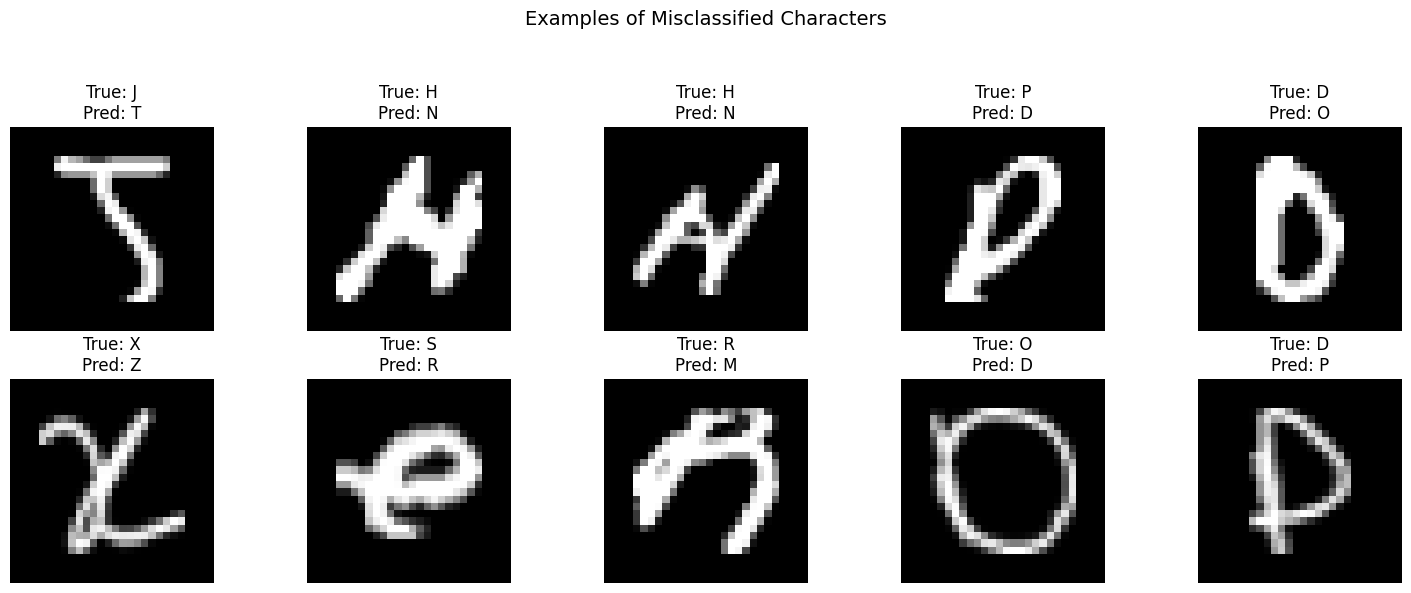

In [21]:
# Step 16: Visualizing Misclassified Characters

# Identify indices where the predicted label does not match the true label
wrong_indices = [i for i in range(len(all_preds)) if all_preds[i] != all_labels[i]]

# Plot the first 10 misclassified images
plt.figure(figsize=(15, 6))
for i, idx in enumerate(wrong_indices[:10]):
    img = X_test[idx].squeeze()  # Remove channel dimension
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {classes[y_test[idx]]}\nPred: {classes[all_preds[idx]]}")
    plt.axis('off')

plt.suptitle("Examples of Misclassified Characters", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

C:\Users\VANSH\AppData\Local\Temp\ipykernel_3032\1781327106.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=class_accuracy * 100, palette="viridis")


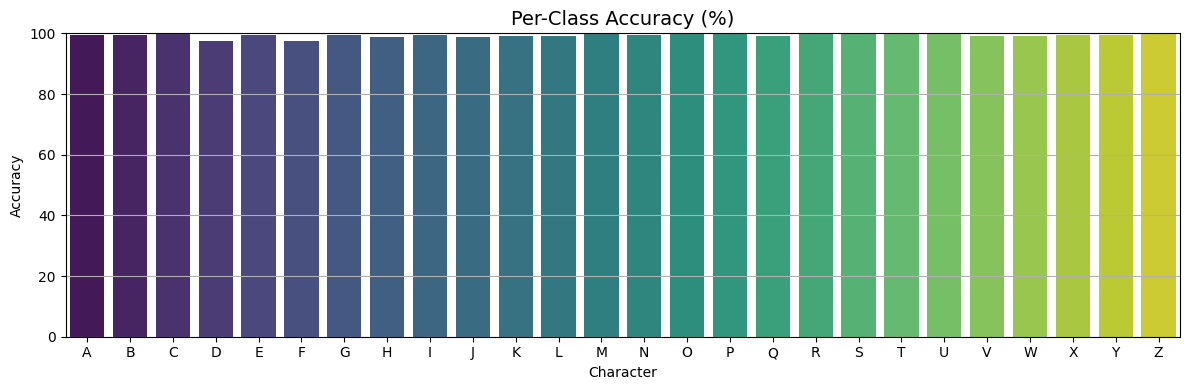

In [22]:
# Step 17: Visualizing Per-Class Accuracy

# Extract diagonal (true positives) and compute per-class accuracy
cm_diag = np.diag(cm)                         # Correct predictions per class
class_accuracy = cm_diag / cm.sum(axis=1)    # Accuracy = TP / Total actual for each class

# Plotting per-class accuracy
plt.figure(figsize=(12, 4))
sns.barplot(x=classes, y=class_accuracy * 100, palette="viridis")
plt.title("Per-Class Accuracy (%)", fontsize=14)
plt.ylabel("Accuracy")
plt.xlabel("Character")
plt.ylim(0, 100)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [23]:
# Step 18: Save the Trained Model

# Save the model's learned parameters to a .pt file
model_save_path = "C:/Users/VANSH/OneDrive/Desktop/Project/Character_recognition/Model/character_cnn_model.pt"
torch.save(model.state_dict(), model_save_path)

print(f"Model saved successfully at:\n{model_save_path}")

Model saved successfully at:
C:/Users/VANSH/OneDrive/Desktop/Project/Character_recognition/Model/character_cnn_model.pt
